In [7]:
#Necessary libraries and modules needed for building the classification model

import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
#from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [8]:
#Image dataset preprocessing parameters

# Dimension for the resized images
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images needed for training
N_IMAGES = 100

# dataset folder path
root_dir = "PlantVillage"

train_dir = "train"

val_dir = "val"

In [9]:
#function "convert_image_to_array" resizes an image to the size DEFAULT_IMAGE_SIZE stated above.

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [10]:
#The training data images are Loaded by traversing through all the folders then the images and labels are converted 
#into separate lists respectively.

#Due to Computing Limitations a small portion of the dataset is being used. Tweak N_IMAGES to include entire dataset.

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing background ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot 

In [11]:
#To know the number of classes/labels in the training dataset

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  39


In [12]:
#FOR AUGMENTING AND SPLITTING THE DATASET
#"ImageDataGenerator" is used for augmenting data by performing different operations on the training images

augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [13]:
#The dataset is split into TEST and TRAIN data for validation purpose

print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


In [8]:
#Used Hyperparameters

EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [9]:
#A Sequential model and use of different layers such as Convolutional,Normalization,Pooling,Dropout and Activation layers

model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0

In [11]:
# An Adam optimizer is initialized with learning rate and decay parameters
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model for training
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Training the model
print("[INFO] Training network...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

[INFO] Training network...
Epoch 1/25
97/97 [==============================] - 57s 470ms/step - loss: 0.5225 - accuracy: 0.0813 - val_loss: 0.2932 - val_accuracy: 0.0205
Epoch 2/25
97/97 [==============================] - 42s 426ms/step - loss: 0.1622 - accuracy: 0.1305 - val_loss: 0.2674 - val_accuracy: 0.0372
Epoch 3/25
97/97 [==============================] - 42s 427ms/step - loss: 0.1185 - accuracy: 0.2448 - val_loss: 0.1675 - val_accuracy: 0.1192
Epoch 4/25
97/97 [==============================] - 42s 430ms/step - loss: 0.1035 - accuracy: 0.3394 - val_loss: 0.1308 - val_accuracy: 0.2295
Epoch 5/25
97/97 [==============================] - 41s 424ms/step - loss: 0.0891 - accuracy: 0.4116 - val_loss: 0.1423 - val_accuracy: 0.1923
Epoch 6/25
97/97 [==============================] - 42s 427ms/step - loss: 0.0810 - accuracy: 0.4657 - val_loss: 0.1325 - val_accuracy: 0.1808
Epoch 7/25
97/97 [==============================] - 42s 429ms/step - loss: 0.0704 - accuracy: 0.5512 - val_loss: 0.

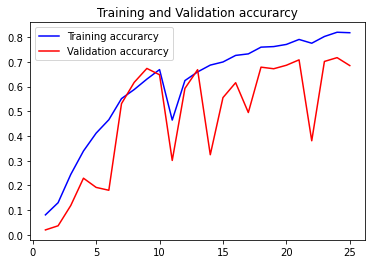

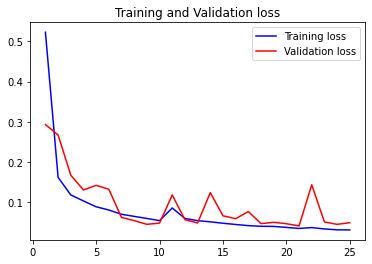

In [12]:
#EVALUATE MODEL
#The accuracy and loss are compared by plotting graphs of training and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [14]:
#Evaluation of model accuracy

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
25/25 [==============================] - 2s 60ms/step - loss: 0.0495 - accuracy: 0.6846
Test Accuracy: 68.46153736114502


In [15]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


In [17]:
#Test of Model using trained model
#"predict_disease" function predicts the disease of the plant and also shows the image.The image path has to be given.

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict(np_image)
    #result=np.argmax(result,axis=1)
    #print((image_labels.classes_[result][0]))
    itemindex = np.where(result==np.max(result))
    print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

In [19]:
#Saving model after Training

model.save('model.h5')


In [14]:
#Loading model

from tensorflow import keras
new_model = keras.models.load_model('model.h5')

In [10]:
#Accuracy of Loaded model

print("[INFO] Calculating model accuracy")
scores = new_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
25/25 [==============================] - 7s 82ms/step - loss: 0.0495 - accuracy: 0.6846
Test Accuracy: 68.46153736114502


In [17]:
#Test model using Loaded model

def predict_disease(image_path):
    global DiseaseVal
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    
    result = new_model.predict(np_image)
    
    #result=np.argmax(result,axis=1)
    
    #print((image_labels.classes_[result][0]))
    
    
    itemindex = np.where(result==np.max(result))
    probValue=np.max(result)
    diseaseClass=str(label_binarizer.classes_[itemindex[1][0]])
    if 'healthy' not in (label_binarizer.classes_[itemindex[1][0]]):
        print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])
    
    
        for x,y in SevTab:
            if x==diseaseClass:
                value=y
        value2=value.astype(float)
        rating=probValue*value2
        DiseaseVal=rating
        print("Severity rating=",rating)
    else:
        DiseaseVal=0
        print(label_binarizer.classes_[itemindex[1][0]])

Apple___healthy


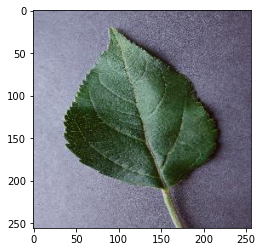

In [18]:
#The testing is done by selecting an image from "Test" dataset and the class/disease is predicted

predict_disease("C://Users//User//Desktop//Plant Disease Combined code//val//Apple___healthy//0afaaf78-6ec5-49ee-a070-f6217039ed2d___RS_HL 7827.JPG")

probability:0.80421984
Apple___Apple_scab
Severity rating= 0.1598291233728528


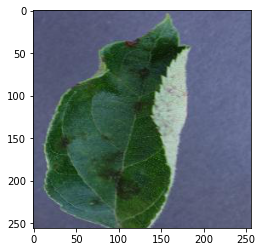

In [19]:
predict_disease("C://Users//User//Desktop//Plant Disease Combined code//val//Apple___Apple_scab//5a923f64-b733-47a7-90f5-2786cd9c85ce___FREC_Scab 3234.JPG")

probability:0.99837816
Apple___Black_rot
Severity rating= 0.1952663942278385


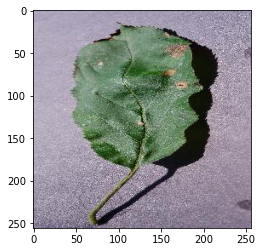

In [20]:
predict_disease("C://Users//User//Desktop//Plant Disease Combined code//val//Apple___Black_rot//1d0e83a0-f3c0-4c14-b1d6-b0ceee3552ac___JR_FrgE.S 3006.JPG")

probability:0.5837525
Apple___Cedar_apple_rust
Severity rating= 0.050640997498846055


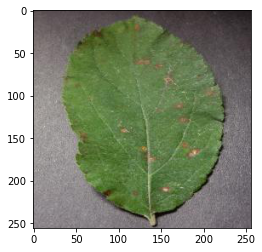

In [21]:
predict_disease("C://Users//User//Desktop//Plant Disease Combined code//val//Apple___Cedar_apple_rust//3fb3806c-db88-491d-b9b0-191b3d5964cd___FREC_C.Rust 4130.JPG")

Grape___healthy


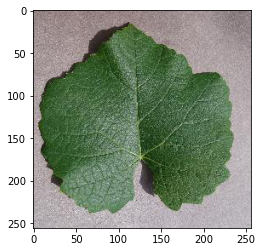

In [22]:
predict_disease("C://Users//User//Desktop//Plant Disease Combined code//val//Grape___healthy//0c1667a2-61d7-4dee-b4d9-0d141a1ceb20___Mt.N.V_HL 9127.JPG")

probability:0.5331898
Grape___Esca_(Black_Measles)
Severity rating= 0.1815567697086334


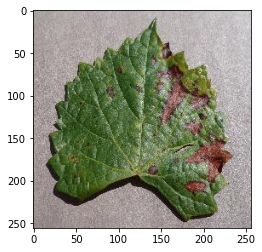

In [23]:
predict_disease("C://Users//User//Desktop//Plant Disease Combined code//val//Grape___Esca_(Black_Measles)//0a29217d-3154-4541-8d23-9c5e8d9eeb85___FAM_B.Msls 4446.JPG")

probability:0.5448076
Grape___Black_rot
Severity rating= 0.1581969851333499


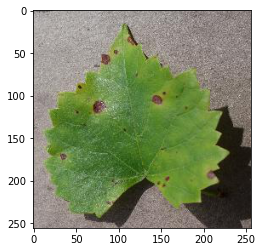

In [25]:
predict_disease("C://Users//User//Desktop//Plant Disease Combined code//val//Grape___Black_rot//1d3c0f3d-1b66-4cfc-b67b-af9760864e99___FAM_B.Rot 3317.JPG")

probability:0.9999999
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Severity rating= 0.26484156842842105


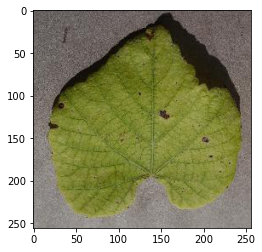

In [26]:
predict_disease("C://Users//User//Desktop//Plant Disease Combined code//val//Grape___Leaf_blight_(Isariopsis_Leaf_Spot)//00a962ad-573b-44b1-97ae-912a6bd6e0b0___FAM_L.Blight 1431.JPG")

In [16]:
SevTab=np.array([["Apple___Apple_scab",0.1987381],["Apple___Black_rot",0.1955836],["Apple___Cedar_apple_rust",0.0867508],["Cherry_(including_sour)___Powdery_mildew",0.5517693],["Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",0.1331169],["Corn_(maize)___Common_rust_",0.3094156],["Corn_(maize)___Northern_Leaf_Blight",0.2558442],["Grape___Black_rot",0.2903722],["Grape___Esca_(Black_Measles)",0.3405106],["Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",0.2648416],["Peach___Bacterial_spot",0.8645343],["Pepper,_bell___Bacterial_spot",0.4025253],["Potato___Early_blight",0.4648460],["Potato___Late_blight",0.4648460 ],["Strawberry___Leaf_scorch",0.7090323],["Tomato___Bacterial_spot",0.1171450],["Tomato___Early_blight",0.0550623],["Tomato___Late_blight",0.1051001],["Tomato___Leaf_Mold",0.0523780],["Tomato___Septoria_leaf_spot",0.0975291],["Tomato___Spider_mites Two-spotted_spider_mite",0.0922982],["Tomato___Target_Spot",0.0772937],["Tomato___Tomato_mosaic_virus",0.0205796],["Tomato___Tomato_Yellow_Leaf_Curl_Virus",0.2949962]])




# PLANT DISEASE CLASSIFICATION(Grayscale)

In [25]:
#Necessary libraries and modules needed for building the classification model

import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
#from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [26]:
#Image dataset preprocessing parameters

# Dimension for the resized images
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images needed for training
N_IMAGES = 100

# dataset folder path
root_dir = "PlantVillage_Grayscale"

train_dir = "grayscale_train"

val_dir = "grayscale_test"

In [27]:
#function "convert_image_to_array" resizes an image to the size DEFAULT_IMAGE_SIZE stated above.

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [28]:
#The training data images are Loaded by traversing through all the folders then the images and labels are converted 
#into separate lists respectively.

#Due to Computing Limitations a small portion of the dataset is being used. Tweak N_IMAGES to include entire dataset.

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bel

In [29]:
#To know the number of classes/labels in the training dataset

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  38


In [30]:
#FOR AUGMENTING AND SPLITTING THE DATASET
#"ImageDataGenerator" is used for augmenting data by performing different operations on the training images

augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [31]:
#The dataset is split into TEST and TRAIN data for validation purpose

print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Splitting data to train and test...


In [8]:
#Used Hyperparameters

EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [9]:
#A Sequential model and use of different layers such as Convolutional,Normalization,Pooling,Dropout and Activation layers

model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [10]:
# An Adam optimizer is initialized with learning rate and decay parameters
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model for training
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Training the model
print("[INFO] Training network...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

C:\Users\CVIS-3865\.conda\envs\tf_gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[INFO] Training network...
Epoch 1/25
95/95 [==============================] - 40s 343ms/step - loss: 0.4977 - accuracy: 0.0589 - val_loss: 0.1936 - val_accuracy: 0.0237
Epoch 2/25
95/95 [==============================] - 31s 326ms/step - loss: 0.1131 - accuracy: 0.1839 - val_loss: 0.6020 - val_accuracy: 0.0237
Epoch 3/25
95/95 [==============================] - 31s 325ms/step - loss: 0.0948 - accuracy: 0.3033 - val_loss: 0.1947 - val_accuracy: 0.0355
Epoch 4/25
95/95 [==============================] - 31s 325ms/step - loss: 0.0878 - accuracy: 0.3648 - val_loss: 0.2999 - val_accuracy: 0.0974
Epoch 5/25
95/95 [==============================] - 31s 328ms/step - loss: 0.0796 - accuracy: 0.4270 - val_loss: 0.5222 - val_accuracy: 0.1763
Epoch 6/25
95/95 [==============================] - 31s 328ms/step - loss: 0.0832 - accuracy: 0.4303 - val_loss: 0.1590 - val_accuracy: 0.2303
Epoch 7/25
95/95 [==============================] - 31s 328ms/step - loss: 0.0771 - accuracy: 0.4826 - val_loss: 0.

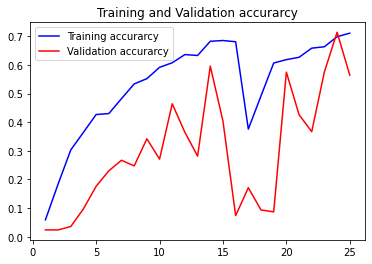

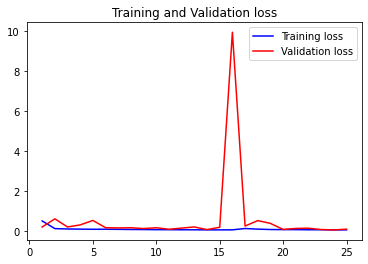

In [11]:
#EVALUATE MODEL
#The accuracy and loss are compared by plotting graphs of training and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [12]:
#Evaluation of model accuracy

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
24/24 [==============================] - 1s 22ms/step - loss: 0.0862 - accuracy: 0.5645
Test Accuracy: 56.44736886024475


In [33]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


In [15]:
#Test of Model using trained model
#"predict_disease" function predicts the disease of the plant and also shows the image.The image path has to be given.

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict(np_image)
    #result=np.argmax(result,axis=1)
    #print((image_labels.classes_[result][0]))
    itemindex = np.where(result==np.max(result))
    print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

In [16]:
#Saving model after Training

model.save('model_grayscale.h5')


In [32]:
#Loading model

from tensorflow import keras
new_model = keras.models.load_model('model_grayscale.h5')

In [ ]:
#Accuracy of Loaded model

print("[INFO] Calculating model accuracy")
scores = new_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [34]:
#Test model using Loaded model

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = new_model.predict(np_image)
    #result=np.argmax(result,axis=1)
    #print((image_labels.classes_[result][0]))
    itemindex = np.where(result==np.max(result))
    print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])
    

probability:0.99865735
Blueberry___healthy


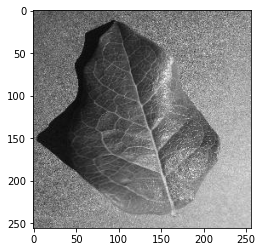

In [35]:
#The testing is done by selecting an image from "Test" dataset and the class/disease is predicted

predict_disease("C://Users//User//Desktop//Plant Disease Combined code//grayscale_test//Blueberry___healthy//0a0b8f78-df2d-4cfc-becf-cde10fa2766b___RS_HL 5487.JPG")

# Plant Disease CLASSIFICATION(SEGMENTED)

In [36]:
#Necessary libraries and modules needed for building the classification model

import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
#from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [37]:
#Image dataset preprocessing parameters

# Dimension for the resized images
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images needed for training
N_IMAGES = 100

# dataset folder path
root_dir = "PlantVillage_Segmented"

train_dir = "segmented_train"

val_dir = "segmented_test"

In [38]:
#function "convert_image_to_array" resizes an image to the size DEFAULT_IMAGE_SIZE stated above.

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [39]:
#The training data images are Loaded by traversing through all the folders then the images and labels are converted 
#into separate lists respectively.

#Due to Computing Limitations a small portion of the dataset is being used. Tweak N_IMAGES to include entire dataset.

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bel

In [40]:
#To know the number of classes/labels in the training dataset

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  38


In [41]:
#FOR AUGMENTING AND SPLITTING THE DATASET
#"ImageDataGenerator" is used for augmenting data by performing different operations on the training images

augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [42]:
#The dataset is split into TEST and TRAIN data for validation purpose

print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Splitting data to train and test...


In [22]:
#Used Hyperparameters

EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [23]:
#A Sequential model and use of different layers such as Convolutional,Normalization,Pooling,Dropout and Activation layers

model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [24]:
# An Adam optimizer is initialized with learning rate and decay parameters
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model for training
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Training the model
print("[INFO] Training network...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

C:\Users\CVIS-3865\.conda\envs\tf_gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[INFO] Training network...
Epoch 1/25
95/95 [==============================] - 36s 348ms/step - loss: 0.5199 - accuracy: 0.0520 - val_loss: 0.1760 - val_accuracy: 0.0237
Epoch 2/25
95/95 [==============================] - 30s 311ms/step - loss: 0.1284 - accuracy: 0.1618 - val_loss: 0.1768 - val_accuracy: 0.0197
Epoch 3/25
95/95 [==============================] - 30s 312ms/step - loss: 0.1091 - accuracy: 0.2260 - val_loss: 0.1917 - val_accuracy: 0.0447
Epoch 4/25
95/95 [==============================] - 30s 314ms/step - loss: 0.1066 - accuracy: 0.2878 - val_loss: 1.3900 - val_accuracy: 0.0566
Epoch 5/25
95/95 [==============================] - 30s 311ms/step - loss: 0.1054 - accuracy: 0.3020 - val_loss: 4.3066 - val_accuracy: 0.0895
Epoch 6/25
95/95 [==============================] - 30s 310ms/step - loss: 0.1149 - accuracy: 0.2747 - val_loss: 0.1580 - val_accuracy: 0.2276
Epoch 7/25
95/95 [==============================] - 30s 311ms/step - loss: 0.1006 - accuracy: 0.3424 - val_loss: 0.

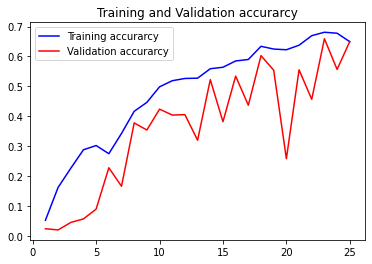

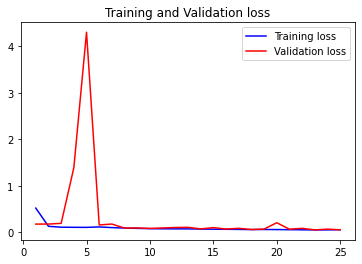

In [25]:
#EVALUATE MODEL
#The accuracy and loss are compared by plotting graphs of training and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [26]:
#Evaluation of model accuracy

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
24/24 [==============================] - 1s 21ms/step - loss: 0.0535 - accuracy: 0.6500
Test Accuracy: 64.99999761581421


In [44]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


In [28]:
#Test of Model using trained model
#"predict_disease" function predicts the disease of the plant and also shows the image.The image path has to be given.

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict(np_image)
    #result=np.argmax(result,axis=1)
    #print((image_labels.classes_[result][0]))
    itemindex = np.where(result==np.max(result))
    print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

In [29]:
#Saving model after Training

model.save('model_segmented.h5')


In [43]:
#Loading model

from tensorflow import keras
new_model = keras.models.load_model('model_segmented.h5')

In [ ]:
#Accuracy of Loaded model

print("[INFO] Calculating model accuracy")
scores = new_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [45]:
#Test model using Loaded model

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = new_model.predict(np_image)
    #result=np.argmax(result,axis=1)
    #print((image_labels.classes_[result][0]))
    itemindex = np.where(result==np.max(result))
    print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.95178246
Blueberry___healthy


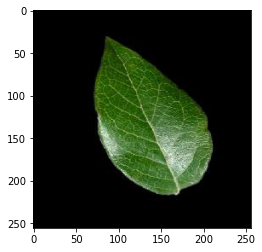

In [46]:
#The testing is done by selecting an image from "Test" dataset and the class/disease is predicted

predict_disease("C://Users//User//Desktop//Plant Disease Combined code//segmented_test//Blueberry___healthy//0b344c16-456c-4085-aa61-6a1c4cb93632___RS_HL 2538_final_masked.JPG")

# WEATHER FACTORS

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [28]:
dataset = pd.read_csv("cpdata.csv")

In [29]:
X = dataset.drop('label', axis=1)
y = dataset['label']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [31]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [32]:
def weatheranalysis(s):
    required=s

    atemp=22.75088787
    shum=90.69489172
    pH=5.521466996
    rain=110.4317855

    L=[]
    L.append(atemp)
    L.append(shum)
    L.append(pH)
    L.append(rain)
    predictcrop=[L]


    global WeatherVal

    #X_test=[[20.879744,	82.002744,6.502985,	202.935536]
    y_pred = classifier.predict(predictcrop)
    if y_pred==required:
        WeatherVal=1
        print(y_pred)
    
    else:
        WeatherVal=0
        print("AREA DOES NOT CONTAIN FAVOURABLE WEATHER CONDITIONS")

# LOSS FUNCTION

In [33]:
def Lossfunction():
    LOSSFUNCTION = (WeatherVal)*(DiseaseVal)
    if(LOSSFUNCTION==0 and WeatherVal==0):
        print("AREA NOT RECOMMENDED FOR PLANTING THE REQUIRED PLANT")
    elif(LOSSFUNCTION==0 and DiseaseVal==0):
        print("AREA IS RECOMMENDED AND PLANT IS DISEASE-FREE")
    else:
        print(LOSSFUNCTION)
    
    
    

# Example 1:

## SUITABLE AREA AND DISEASE FREE HEALTHY APPLE LEAF


In [34]:
weatheranalysis('apple')

['apple']


C:\Users\User\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Apple___healthy


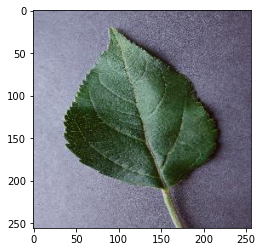

In [35]:
predict_disease("C://Users//User//Desktop//Plant Disease Combined code//val//Apple___healthy//0afaaf78-6ec5-49ee-a070-f6217039ed2d___RS_HL 7827.JPG")

In [36]:
Lossfunction()

AREA IS RECOMMENDED AND PLANT IS DISEASE-FREE


# Example 2:
## NOT SUITABLE AREA FOR REQUIRED PLANT

In [37]:
weatheranalysis('watermelon')

AREA DOES NOT CONTAIN FAVOURABLE WEATHER CONDITIONS


C:\Users\User\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [38]:
Lossfunction()

AREA NOT RECOMMENDED FOR PLANTING THE REQUIRED PLANT


# Example 3:
## SUITABLE AREA BUT DISEASED APPLE PLANT LEAF (BLACK ROT) 

In [39]:
weatheranalysis('apple')

['apple']


C:\Users\User\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


probability:0.99837816
Apple___Black_rot
Severity rating= 0.1952663942278385


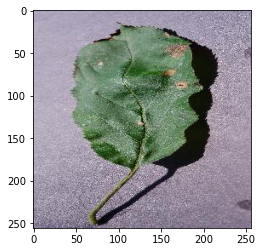

In [40]:
predict_disease("C://Users//User//Desktop//Plant Disease Combined code//val//Apple___Black_rot//1d0e83a0-f3c0-4c14-b1d6-b0ceee3552ac___JR_FrgE.S 3006.JPG")

In [41]:
Lossfunction()

0.1952663942278385
